In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import t as student_t
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
# Build bootstrap samples DataFrame for single-recording tasks
import pandas as pd
from dataclasses import dataclass
from typing import Optional
import math
import time
from typing import Dict, List, Tuple, Optional
from dataclasses import dataclass
import numpy as np
import wandb
from omegaconf import OmegaConf
import equinox as eqx
import jax
import jax.numpy as jnp
from jax import random as jr

from foundational_ssm.utils.wandb_utils_jax import load_model_and_state_from_checkpoint_wandb
from foundational_ssm.utils.downstream_utils import validate_one_epoch, get_nlb_datasets
from foundational_ssm.models import SSMDownstreamDecoder
from sklearn.metrics import r2_score

# Build agg_df with sample lists and patch with bootstrap samples for single-recording tasks
from typing import Dict, Tuple

def downstream_checkpoint_artifact(run_name: str, alias: str) -> str:
    # Note: downstream sweep project name; run_name is exact W&B run display name
    return f"melinajingting-ucl/foundational_ssm_downstream_sweep/{run_name}_checkpoint:{alias}"

def load_eval_split(dataset_name: str, phase: str = "test", batch_size: int = 64, rng_seed: int = 0):
    # Build a minimal dataset cfg for get_nlb_datasets
    ds_cfg = OmegaConf.create({
        "name": dataset_name,
        "phase": phase,
        "batch_size": batch_size,
        "skip_timesteps": 60,
    })
    key = jr.PRNGKey(rng_seed)
    try:
        train_data, val_data = get_nlb_datasets(ds_cfg, key, return_full=False)
        # When phase=='test', get_nlb_datasets should return (train, test) or (None, test)
        eval_data = val_data
    except Exception:
        # Fallback: set phase explicitly and re-try
        ds_cfg.phase = phase
        train_data, eval_data = get_nlb_datasets(ds_cfg, key, return_full=False)
    return eval_data, ds_cfg

def eval_model_once(eval_batch: Dict[str,np.ndarray], model, state, skip_timesteps: int = 60) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Run a single full-batch eval to get predictions and targets, respecting mask.
    Returns (preds, targets, mask) as numpy arrays with skip_timesteps cropped."""
    batch = {k: jax.device_put(np.array(v)) for k, v in eval_batch.items()}
    inputs = batch["neural_input"]
    targets = batch["behavior_input"]
    mask = batch["mask"]
    mask = mask[..., None]
    inf_model = eqx.nn.inference_mode(model)
    preds, _state = jax.vmap(inf_model, axis_name="batch", in_axes=(0, None, None), out_axes=(0, None))(inputs, state, jr.PRNGKey(0))
    preds = np.array(preds)
    targets = np.array(targets)
    mask = np.array(mask)
    if skip_timesteps > 0:
        preds = preds[:, skip_timesteps:, :]
        targets = targets[:, skip_timesteps:, :]
        mask = mask[:, skip_timesteps:, :]
    preds = np.where(mask, preds, 0)
    targets = np.where(mask, targets, 0)
    return preds, targets, mask


def bootstrap_r2_from_trials(
    preds: np.ndarray,
    targets: np.ndarray,
    P: float = 1/6,
    B: int = 1000,
    rng: Optional[np.random.Generator] = None,
    replace: bool = False,
) -> np.ndarray:
    """Draw B subsamples of trials of size ~= P*N and compute R² for each.

    Args:
        preds: array (trials, timesteps, 2)
        targets: array (trials, timesteps, 2)
        P: proportion of trials per subsample (0 < P <= 1)
        B: number of resamples
        rng: optional NumPy Generator
        replace: if True, sample with replacement (bootstrap-style). If False, without replacement.

    Returns:
        r2_samples: shape (B,) of R² values.
    """
    N = int(preds.shape[0])
    m = max(1, min(N, int(round(P * N))))
    r2_samples = np.zeros((B,), dtype=float)
    rng = np.random.default_rng() if rng is None else rng

    for i in range(B):
        idx = rng.choice(N, size=m, replace=replace)
        preds_b = preds[idx].reshape(-1, 2)
        targets_b = targets[idx].reshape(-1, 2)
        r2_samples[i] = r2_score(targets_b, preds_b)
    return r2_samples

@dataclass
class BootstrapRequest:
    task: str
    opt_mode: str
    checkpoint_short: str
    train_mode: str
    run_name: str  # W&B display name


def bootstrap_samples_for_request(req: BootstrapRequest, B: int = 500) -> Optional[pd.DataFrame]:
    art = downstream_checkpoint_artifact(req.run_name, 'latest')
    model, state, _ = load_model_and_state_from_checkpoint_wandb(art, model_cls=SSMDownstreamDecoder)
    skip_timesteps = 60
    batch_size = 64
    eval_data, _ = load_eval_split(req.task, phase="test", batch_size=batch_size)
    preds, targets, mask = eval_model_once(eval_data, model, state, skip_timesteps=skip_timesteps)
    
    r2 = bootstrap_r2_from_trials(preds, targets, B=B)
    # print(f"overall R2 for {req.run_name}",r2_score(targets.reshape(-1,2), preds.reshape(-1,2), sample_weight=mask.reshape(-1)))
    # print(r2)
    df = pd.DataFrame({
        'task': req.task,
        'opt_mode': req.opt_mode,
        'checkpoint_short': req.checkpoint_short,
        'train_mode': req.train_mode,
        'run_name': req.run_name,
        'sample': np.arange(len(r2)),
        'r2': r2,
    })
    return df

def pm_task_from_dataset(ds: str) -> str:
    # Handle multiple naming styles:
    # - pm_* suffixes: *_co -> center_out, *_rt -> random_target
    # - recording ids like t_YYYYMMDD_center_out_reaching / random_target_reaching
    if not isinstance(ds, str):
        return "unknown"
    if ds.endswith("_co") or "center_out_reaching" in ds:
        return "pm_center_out"
    if ds.endswith("_rt") or "random_target_reaching" in ds:
        return "pm_random_target"
    return ds  # fallback to original label

def build_bootstrap_samples_df(raw_df: pd.DataFrame, tasks=("mc_rtt_prepend","mc_area2bump_prepend"), B: int = 500) -> pd.DataFrame:
    samples = []
    for task in tasks:
        tdf = raw_df[raw_df['task'] == task] if 'task' in raw_df.columns else raw_df[raw_df['dataset'] == task]
        if tdf.empty:
            continue
        for (om, ck, tm), g in tdf.groupby(['opt_mode','checkpoint_short','train_mode']):
            if g.empty or 'run_name' not in g.columns:
                continue
            run_name = g['run_name'].iloc[0]
            req = BootstrapRequest(task=task, opt_mode=str(om), checkpoint_short=ck, train_mode=tm, run_name=run_name)
            df = bootstrap_samples_for_request(req, B=B)
            if df is not None:
                samples.append(df)
    if not samples:
        bs_df = pd.DataFrame(columns=['task','opt_mode','checkpoint_short','train_mode','run_name','sample','r2'])
    else:
        bs_df = pd.concat(samples, ignore_index=True)
    return bs_df

# Patch with bootstrap samples (store samples + overwrite mean/std/n if needed)

def patch_agg_df_with_bootstrap_samples(agg_df_in: pd.DataFrame, raw_df: pd.DataFrame, tasks=("mc_rtt_prepend","mc_area2bump_prepend"), B: int = 500) -> pd.DataFrame:
    out = agg_df_in.copy()
    bs_df_local = build_bootstrap_samples_df(raw_df, tasks=tasks, B=B)
    if bs_df_local is None or len(bs_df_local) == 0:
        return out
    key_cols = ["task","opt_mode","checkpoint_short","train_mode"]
    for key, g in bs_df_local.groupby(key_cols):
        task, opt_mode, ck, tm = key
        idx = out[(out["task"] == task) & (out["opt_mode"].astype(str) == str(opt_mode)) & (out["checkpoint_short"] == ck) & (out["train_mode"] == tm)].index
        if len(idx) == 0:
            continue
        samples = g["r2"].astype(float).values
        s = float(np.nanstd(samples, ddof=1)) if len(samples) > 1 else 0.0
        n = int(len(samples))
        out.loc[idx, "r2_mean"] = samples.mean()
        out.loc[idx, "r2_std"] = s
        out.loc[idx, "n"] = n
        out.loc[idx, "r2_sample_source"] = "bootstrap"
        out.loc[idx, "r2_samples"] = tuple(samples)
    return out

def _infer_task_from_dataset(ds: str) -> str:
    if not isinstance(ds, str):
        return "unknown"
    if ds.endswith("_co") or "center_out" in ds:
        return "pm_center_out"
    if ds.endswith("_rt") or "random_target" in ds:
        return "pm_random_target"
    return ds

In [12]:
DOWNSTREAM_PROJECT = "melinajingting-ucl/foundational_ssm_downstream_sweep"
api = wandb.Api()
runs = api.runs(DOWNSTREAM_PROJECT, filters={"state": "finished"})

records = []
for r in runs:
    cfg = r.config or {}
    # Extract sweep origin if present
    sweep_name = r.sweep.name if getattr(r, "sweep", None) else None
    # Find all final/r2/* in summary
    for k, v in r.summary.items():
        if isinstance(k, str) and k.startswith("final/r2/"):
            dataset = k[len("final/r2/"):]
            records.append({
                "run_id": r.id,
                "run_name": r.display_name,
                "sweep": sweep_name,
                "dataset": dataset,
                "r2": v,
                # Key config axes for comparisons
                "from_scratch": cfg.get("training.from_scratch"),
                "opt_mode": cfg.get("optimizer.mode"),  # all vs encoder_only
                "checkpoint": cfg.get("model.checkpoint"),
                "dataset_name": cfg.get("dataset.name") or cfg.get("dataset_args.recording_id"),
            })

downstream_df = pd.DataFrame.from_records(records)
downstream_df["task"] = downstream_df["dataset"].apply(_infer_task_from_dataset)
downstream_df["train_mode"] = downstream_df["from_scratch"].map({True: "scratch", False: "finetune"}).fillna("unknown")
downstream_df["checkpoint_short"] = downstream_df["checkpoint"].apply(lambda s: s.split("/")[-1].split(":")[0] if isinstance(s, str) else s)
downstream_df["train_mode"] = downstream_df["train_mode"].astype(str).str.lower()
downstream_df["is_pm"] = downstream_df["dataset"].apply(lambda dataset: isinstance(dataset, str) and (dataset.startswith("pm_") or "perich_miller" in dataset or dataset.startswith("t_")))



In [14]:
# Aggregated (mean/std) per (checkpoint, train_mode, opt_mode, task)
agg_cols = ["checkpoint_short", "train_mode", "opt_mode", "task"]
pm_agg = (
    downstream_df[downstream_df["is_pm"]]
    .groupby(agg_cols)
    .agg(r2_mean=("r2", "mean"), r2_std=("r2", "std"), n=("r2", "count"))
    .reset_index()
)

nlb_agg = (
    downstream_df[~downstream_df["is_pm"]]
    .groupby(agg_cols)
    .agg(r2_mean=("r2", "mean"), r2_std=("r2", "std"), n=("r2", "count"))
    .reset_index()
)

agg_df = pd.concat([pm_agg, nlb_agg], ignore_index=True, sort=False)

In [ ]:
tasks=("mc_rtt_prepend","mc_area2bump_prepend")
B=100
out = agg_df.copy()
samples = []
for task in tasks:
    tdf = downstream_df[downstream_df['task'] == task] if 'task' in downstream_df.columns else downstream_df[downstream_df['dataset'] == task]
    if tdf.empty:
        continue
    for (om, ck, tm), g in tdf.groupby(['opt_mode','checkpoint_short','train_mode']):
        if g.empty or 'run_name' not in g.columns:
            continue
        run_name = g['run_name'].iloc[0]
        req = BootstrapRequest(task=task, opt_mode=str(om), checkpoint_short=ck, train_mode=tm, run_name=run_name)
        df = bootstrap_samples_for_request(req, B=B)
        if df is not None:
            samples.append(df)
bs_df = pd.concat(samples, ignore_index=True)
    
key_cols = ["task","opt_mode","checkpoint_short","train_mode"]
for key, g in bs_df.groupby(key_cols):
    task, opt_mode, ck, tm = key
    idx = out[(out["task"] == task) & (out["opt_mode"].astype(str) == str(opt_mode)) & (out["checkpoint_short"] == ck) & (out["train_mode"] == tm)].index
    if len(idx) == 0:
        continue
    samples = g["r2"].astype(float).values
    s = float(np.nanstd(samples, ddof=1)) if len(samples) > 1 else 0.0
    n = int(len(samples))
    out.loc[idx, "r2_mean"] = samples.mean()
    out.loc[idx, "r2_std"] = s
    out.loc[idx, "n"] = n
    out.loc[idx, "r2_sample_source"] = "bootstrap"

out.to_csv("results/main_downstream_performances_with_std.csv", index=False)

In [ ]:
import os
from typing import Iterable
from tqdm import tqdm

# Try to load downstream_df from CSV if available, else expect it to exist in the notebook state.
try:
    downstream_df = pd.read_csv("results/raw_downstream_performances.csv")
except Exception:
    if 'downstream_df' not in globals():
        raise FileNotFoundError("results/raw_downstream_performances.csv not found and no in-memory downstream_df. Run the earlier data collection cell or provide the CSV.")

# Helper: resolve best vs epoch_0 artifacts for a run_name

def _ckpt_artifact(run_name: str, alias: str) -> str:
    return f"melinajingting-ucl/foundational_ssm_downstream_sweep/{run_name}_checkpoint:{alias}"

# Build a small eval batch for NTK (limit trials to keep NTK feasible)

def load_eval_subset(dataset_name: str, max_trials: int = 64, rng_seed: int = 0):
    from foundational_ssm.utils.downstream_utils import get_nlb_datasets
    from foundational_ssm.loaders import get_brainset_data_loader
    from foundational_ssm.constants import DATA_ROOT
    if dataset_name.startswith("mc_"):
        ds_cfg = OmegaConf.create({
            "name": dataset_name,
            "phase": "test",
            "batch_size": 2048,
            "skip_timesteps": 60,
        })
        key = jr.PRNGKey(rng_seed)
        train_data, val_data = get_nlb_datasets(ds_cfg, key, return_full=False)
        subset = {k: v[:max_trials] for k, v in train_data.items()}

    else:
        dataset, loader, max_neural_input = get_brainset_data_loader(
            dataset_args={
                'keep_files_open': False,
                'lazy': True,
                'recording_id': dataset_name
            },
            dataloader_args={
                'batch_size': max_trials,
                'num_workers': 2,
                'persistent_workers': True,
            },
            sampler = 'TrialSampler',
            sampler_args = {
                'max_window_length': 5.0
            },
            data_root = '../' + DATA_ROOT,
            prepend_history = 0.3,
            sampling_rate = 200,
            split = 'trial' 
        )
        subset = next(iter(loader))

    return subset

# Wrap model apply as a function f(params, x) -> R^{T*Dout}
# We'll flatten time and output dims for NTK shape stability.

def make_apply_fn_for_ntk(state):
    def f(params, x):
        inf_model = eqx.nn.inference_mode(params)
        preds, _ = jax.vmap(inf_model, axis_name='batch', in_axes=(0, None, None))(x, state, jr.PRNGKey(0))
        y = preds  # [N, T, Dout]
        return y.reshape(y.shape[0], -1)  # [N, T*Dout]
    return f

# Utilities to build random tangent directions over parameter pytrees (float leaves only).

def _tangent_random_normal_like(tree, key):
    leaves, treedef = jax.tree_util.tree_flatten(tree)
    subkeys = jr.split(key, len(leaves))
    tang_leaves = []
    for leaf, sk in zip(leaves, subkeys):
        try:
            arr = jnp.asarray(leaf)
            if jnp.issubdtype(arr.dtype, jnp.floating):
                tang_leaves.append(jr.normal(sk, shape=arr.shape, dtype=arr.dtype))
            else:
                tang_leaves.append(None)  # non-differentiable leaf
        except Exception:
            tang_leaves.append(None)
    return jax.tree_util.tree_unflatten(treedef, tang_leaves)

# Helper: random normals with identical structure to an array-only pytree (e.g., from eqx.partition).

def _randn_like_inexact(tree, key):
    leaves, treedef = jax.tree_util.tree_flatten(tree)
    subkeys = jr.split(key, len(leaves))
    tang_leaves = [jr.normal(sk, shape=jnp.asarray(leaf).shape, dtype=jnp.asarray(leaf).dtype) for leaf, sk in zip(leaves, subkeys)]
    return jax.tree_util.tree_unflatten(treedef, tang_leaves)

# Compute an empirical NTK Gram matrix via random-projection JVPs.
# Return both the averaged K and each projection's Gram contribution G_r = v_r v_r^T for jackknife.

def empirical_ntk_approx_jvp_components(f, params, x, R: int = 16, key: jax.Array = jr.PRNGKey(0)) -> tuple[jax.Array, jax.Array]:
    # Differentiate only w.r.t. array-valued parameters to avoid PyTree mismatches with statics.
    p_arr, p_static = eqx.partition(params, eqx.is_inexact_array)
    def f_arr(p_arr_):
        m = eqx.combine(p_arr_, p_static)
        return f(m, x)  # [N, D]
    keys = jr.split(key, R)
    G_list = []
    for k in keys:
        z_arr = _randn_like_inexact(p_arr, k)
        _, tang = jax.jvp(f_arr, (p_arr,), (z_arr,))  # tang: [N, D]
        G = tang @ tang.T  # [N, N]
        G_list.append(G)
    Gs = jnp.stack(G_list, axis=0)  # [R, N, N]
    K = jnp.mean(Gs, axis=0)
    return K, Gs

# Keep legacy API for callers that only need K.

def empirical_ntk_approx_jvp(f, params, x, R: int = 16, key: jax.Array = jr.PRNGKey(0)) -> jax.Array:
    K, _Gs = empirical_ntk_approx_jvp_components(f, params, x, R=R, key=key)
    return K

# Exact NTK via explicit Jacobians wrt parameters.
# Build Jacobian for each example, flatten (output dims + param dims) per leaf, concatenate leaves -> J in R^{N x M}. Then K = J J^T.

def empirical_ntk_exact_jacobian(f, params, x) -> jax.Array:
    # Split Equinox model into array-valued parameters and static (non-array) fields.
    params_arr, params_static = eqx.partition(params, eqx.is_inexact_array)
    # Define single-example function over only array params; rebuild the full model internally.
    def f_single(p_arr, xi):
        m = eqx.combine(p_arr, params_static)
        y = f(m, xi[None, ...])  # [1, D]
        return y[0]
    # Batched Jacobian over examples: returns pytree leaves shaped [N, D, *param_leaf_shape]
    jac_fun = jax.jit(jax.vmap(jax.jacrev(f_single), in_axes=(None, 0)))
    jac_tree = jac_fun(params_arr, x)
    # Ravel to J in R^{N x M}
    leaves = []
    for leaf in jax.tree_util.tree_leaves(jac_tree):
        if leaf is None:
            continue
        if not jnp.issubdtype(leaf.dtype, jnp.floating):
            continue
        leaves.append(leaf.reshape(leaf.shape[0], -1))  # (N, D * prod(param_shape))
    J = jnp.concatenate(leaves, axis=1) if leaves else jnp.zeros((x.shape[0], 0), dtype=x.dtype)
    return J @ J.T

# Parameter-space utilities: L2 norms over array-valued leaves

def _tree_l2_norm(tree) -> float:
    """Compute sqrt(sum_i ||leaf_i||^2) over float leaves of a pytree."""
    leaves = [jnp.asarray(leaf) for leaf in jax.tree_util.tree_leaves(tree) if leaf is not None]
    if not leaves:
        return 0.0
    # Filter to floating types only (eqx.partition usually ensures this already)
    leaves = [leaf for leaf in leaves if jnp.issubdtype(leaf.dtype, jnp.floating)]
    if not leaves:
        return 0.0
    total = jnp.sum(jnp.stack([jnp.sum(leaf * leaf) for leaf in leaves]))
    return float(jnp.sqrt(total))

# Similarity between two NTK matrices

def kernel_cosine(K1: jnp.ndarray, K2: jnp.ndarray) -> float:
    v1 = jnp.asarray(K1, dtype=jnp.float64).reshape(-1)
    v2 = jnp.asarray(K2, dtype=jnp.float64).reshape(-1)
    num = jnp.vdot(v1, v2).real
    den = jnp.linalg.norm(v1) * jnp.linalg.norm(v2)
    return float(num / (den + 1e-12))

def _jackknife_variance_cosine(G0s: jnp.ndarray, GBs: jnp.ndarray) -> float:
    # G0s, GBs: [R, N, N] projection contributions
    R = int(G0s.shape[0])
    if R <= 1:
        return 0.0
    K0 = jnp.mean(G0s, axis=0)
    KB = jnp.mean(GBs, axis=0)
    thetas = []
    for r in range(R):
        K0_mr = (R * K0 - G0s[r]) / (R - 1)
        KB_mr = (R * KB - GBs[r]) / (R - 1)
        thetas.append(kernel_cosine(K0_mr, KB_mr))
    thetas = jnp.asarray(thetas, dtype=jnp.float64)
    theta_bar = jnp.mean(thetas)
    var = (R - 1) / R * jnp.sum((thetas - theta_bar) ** 2)
    return float(var)

def _bootstrap_variance_cosine(K0: jnp.ndarray, KB: jnp.ndarray, B: int = 200, seed: int = 0) -> float:
    if B <= 1:
        return 0.0
    N = int(K0.shape[0])
    rng = np.random.default_rng(seed)
    thetas = np.zeros(B, dtype=float)
    for b in range(B):
        idx = rng.choice(N, size=N, replace=True)
        K0b = np.asarray(K0)[idx][:, idx]
        KBb = np.asarray(KB)[idx][:, idx]
        thetas[b] = kernel_cosine(K0b, KBb)
    return float(np.var(thetas, ddof=1))

# Iterate runs and compute similarity with uncertainty

def compute_ntk_similarity_for_runs(df: pd.DataFrame, tasks: Iterable[str], max_trials: int = 16, R: int = 16, seed: int = 0, method: str = "jvp", bootstrap_B: int = 200, bootstrap_seed: int = 0):
    rows = []
    for task in tqdm(tasks):
        tdf = df[df["dataset_name"] == task]
        if tdf.empty:
            continue
        for (ck_short, tm, om), g in tdf.groupby(["checkpoint_short", "train_mode", "opt_mode"]):
            if g.empty or 'run_name' not in g.columns:
                continue
            run_name = g['run_name'].iloc[0]
            # Load models
            art_epoch0 = _ckpt_artifact(run_name, 'epoch_0')
            art_best = _ckpt_artifact(run_name, 'best')
            try:
                model0, state0, _ = load_model_and_state_from_checkpoint_wandb(art_epoch0, model_cls=SSMDownstreamDecoder)
                modelB, stateB, _ = load_model_and_state_from_checkpoint_wandb(art_best, model_cls=SSMDownstreamDecoder)
            except Exception as e:
                print(f"skip {run_name} ({task}) due to load error: {e}")
                continue

            # Parameter-space distances
            p0_arr, _ = eqx.partition(model0, eqx.is_inexact_array)
            pB_arr, _ = eqx.partition(modelB, eqx.is_inexact_array)
            diff_arr = jax.tree_util.tree_map(lambda b, a: b - a, pB_arr, p0_arr)
            norm_init = _tree_l2_norm(p0_arr)
            norm_final = _tree_l2_norm(pB_arr)
            norm_diff = _tree_l2_norm(diff_arr)
            param_rel_l2 = float(norm_diff / (norm_init + 1e-12))
            param_abs_l2 = float(norm_diff)

            # Eval subset
            subset = load_eval_subset(task, max_trials=max_trials)
            x = jax.device_put(np.array(subset["neural_input"]))  # [N,T,D]
            # Build apply fns
            f0 = make_apply_fn_for_ntk(state0)
            fB = make_apply_fn_for_ntk(stateB)
            # Compute NTKs and components
            if method == "jacobian":
                K0 = empirical_ntk_exact_jacobian(f0, model0, x)
                KB = empirical_ntk_exact_jacobian(fB, modelB, x)
                proj = 0
                G0s = None
                GBs = None
            else:
                k1 = jr.PRNGKey(seed)
                k2 = jr.PRNGKey(seed + 1)
                K0, G0s = empirical_ntk_approx_jvp_components(f0, model0, x, R=R, key=k1)
                KB, GBs = empirical_ntk_approx_jvp_components(fB, modelB, x, R=R, key=k2)
                proj = int(R)
            # Ensure symmetry and numeric stability
            K0 = 0.5 * (K0 + K0.T)
            KB = 0.5 * (KB + KB.T)
            # Point estimate
            theta = kernel_cosine(K0, KB)
            # Uncertainty components
            var_proj = _jackknife_variance_cosine(G0s, GBs) if (G0s is not None and GBs is not None) else 0.0
            var_boot = _bootstrap_variance_cosine(K0, KB, B=bootstrap_B, seed=bootstrap_seed) if x.shape[0] > 1 else 0.0
            std_proj = float(np.sqrt(max(var_proj, 0.0)))
            std_boot = float(np.sqrt(max(var_boot, 0.0)))
            std_total = float(np.sqrt(std_proj**2 + std_boot**2))
            rows.append({
                'task': task,
                'train_mode': tm,
                'opt_mode': om,
                'checkpoint_short': ck_short,
                'run_name': run_name,
                'ntk_cosine_init_vs_best': theta,
                'ntk_cosine_mean': theta,
                'ntk_cosine_std': std_total,
                'ntk_std_proj': std_proj,
                'ntk_std_boot': std_boot,
                'n_trials': int(x.shape[0]),
                'ntk_method': method,
                'ntk_projections': proj,
                'ntk_bootstrap_B': int(bootstrap_B),
                # Parameter distances
                'param_norm_init': norm_init,
                'param_norm_final': norm_final,
                'param_norm_diff': norm_diff,
                'param_rel_l2': param_rel_l2,
                'param_abs_l2': param_abs_l2,
            })
    return pd.DataFrame(rows)

# Run and plot (use exact Jacobians if model/dataset are small enough)
selected_for_ntk_sim = downstream_df[downstream_df["checkpoint_short"].isin(["l2_reaching_checkpoint"]) & downstream_df["opt_mode"].isin(["all"])]
# selected_for_ntk_sim["task"] = selected_for_ntk_sim[""]
ntk_df = compute_ntk_similarity_for_runs(
    selected_for_ntk_sim, tasks=("mc_rtt_prepend","perich_miller_population_2018/t_20130903_center_out_reaching","mc_area2bump_prepend"), R=32, seed=0, bootstrap_B=50, bootstrap_seed=0
)

wandb:   3 of 3 files downloaded.  ndb: \ 1 of 3 files downloaded...
wandb:   3 of 3 files downloaded.  
/tmp/ipykernel_378943/639917935.py:163: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  v1 = jnp.asarray(K1, dtype=jnp.float64).reshape(-1)
/tmp/ipykernel_378943/639917935.py:164: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  v2 = jnp.asarray(K2, dtype=jnp.float64).reshape(-1)
/tmp/ipykernel_378943/639917935.py:181: UserWarning: Explic

In [ ]:
model0, state0, _ = load_model_and_state_from_checkpoint_wandb(art_epoch0, model_cls=SSMDownstreamDecoder)

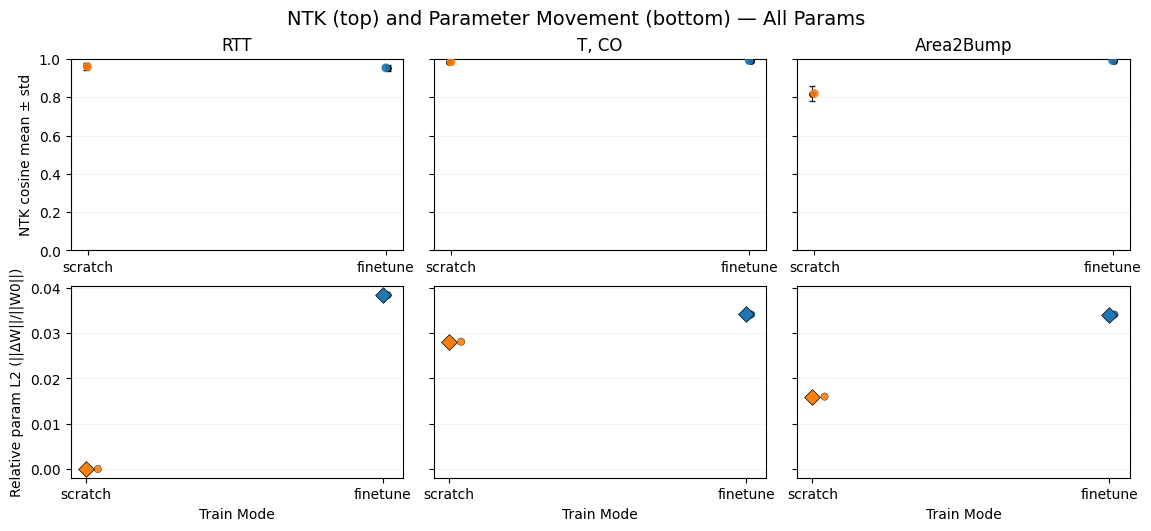

In [25]:
# 2x3 grid: top NTK cosine mean±std, bottom relative parameter L2 across tasks
import numpy as np
import matplotlib.pyplot as plt


def plot_ntk_and_paramrel_grid(
    ntk_df_in,
    tasks=(
        "mc_rtt_prepend",
        "perich_miller_population_2018/t_20130903_center_out_reaching",
        "mc_area2bump_prepend",
    ),
    order=("scratch", "finetune"),
    opt_modes=None,
):
    """Draw a 2xN figure per opt_mode: top row NTK cosine (mean±std), bottom row relative param L2.

    Args:
        ntk_df_in: DataFrame with columns ['task','train_mode','opt_mode','ntk_cosine_mean','ntk_cosine_std','param_rel_l2'].
        tasks: task names to plot as columns.
        order: x-axis order for train_mode categories.
        opt_modes: list of opt_mode values to plot. If None, inferred from data.
    """
    if ntk_df_in is None or len(ntk_df_in) == 0:
        print("ntk_df is empty; compute it first.")
        return

    df = ntk_df_in.copy()
    # Ensure required columns exist/types
    df["train_mode"] = df["train_mode"].astype(str).str.lower()
    df["opt_mode"] = df["opt_mode"].astype(str)
    if "ntk_cosine_mean" not in df.columns and "ntk_cosine_init_vs_best" in df.columns:
        df["ntk_cosine_mean"] = df["ntk_cosine_init_vs_best"].astype(float)
    if "ntk_cosine_std" not in df.columns:
        df["ntk_cosine_std"] = 0.0

    task_titles = {
        "mc_rtt_prepend": "RTT",
        "mc_area2bump_prepend": "Area2Bump",
        "perich_miller_population_2018/t_20130903_center_out_reaching": "T, CO",
    }
    palette = {"scratch": "tab:orange", "finetune": "tab:blue", "unknown": "gray"}

    if opt_modes is None:
        opt_modes = sorted(df["opt_mode"].unique())

    ncols = max(1, len(tasks))

    for om in opt_modes:
        sub = df[df["opt_mode"] == om]
        if sub.empty:
            continue
        fig, axes = plt.subplots(
            2,
            ncols,
            figsize=(3.8 * ncols, 5.2),
            sharey="row",
            constrained_layout=True,
        )
        # Ensure axes is 2D array even if ncols==1
        if ncols == 1:
            axes = np.array(axes).reshape(2, 1)

        for j, task in enumerate(tasks):
            if j >= ncols:
                break
            g = sub[sub["task"] == task].copy()
            ax_top = axes[0, j]
            ax_bot = axes[1, j]

            # Column title
            ax_top.set_title(task_titles.get(task, task))

            # TOP: NTK cosine mean ± std
            ax_top.set_ylim(0, 1)
            ax_top.grid(True, axis="y", alpha=0.15, zorder=0)
            if not g.empty:
                means = g["ntk_cosine_mean"].astype(float).clip(-1, 1).values
                stds = g["ntk_cosine_std"].astype(float).values
                tms = g["train_mode"].astype(str).values
                x_map = {tm: i for i, tm in enumerate(order)}
                rng = np.random.default_rng(0)
                xs_center = np.array([x_map.get(tm, len(order)) for tm in tms], dtype=float)
                xs = xs_center + rng.normal(0, 0.05, size=xs_center.shape)
                colors = [palette.get(tm, "gray") for tm in tms]
                ax_top.errorbar(
                    xs,
                    means,
                    yerr=stds,
                    fmt="o",
                    ms=4,
                    lw=1,
                    ecolor="k",
                    elinewidth=0.8,
                    capsize=2,
                    color="k",
                    alpha=0.85,
                    zorder=2,
                )
                ax_top.scatter(xs_center, means, c=colors, s=28, alpha=0.9, zorder=3)
            ax_top.set_xticks(range(len(order)))
            ax_top.set_xticklabels(order)
            if j == 0:
                ax_top.set_ylabel("NTK cosine mean ± std")
            else:
                ax_top.set_ylabel("")
                ax_top.tick_params(labelleft=False)

            # BOTTOM: relative parameter L2 (||ΔW||/||W0||)
            ax_bot.grid(True, axis="y", alpha=0.15, zorder=0)
            if not g.empty:
                vals = g["param_rel_l2"].astype(float).values
                tms = g["train_mode"].astype(str).values
                x_map = {tm: i for i, tm in enumerate(order)}
                rng = np.random.default_rng(1)
                xs_center = np.array([x_map.get(tm, len(order)) for tm in tms], dtype=float)
                xs = xs_center + rng.normal(0, 0.05, size=xs_center.shape)
                colors = [palette.get(tm, "gray") for tm in tms]
                ax_bot.scatter(
                    xs,
                    vals,
                    c=colors,
                    s=28,
                    alpha=0.9,
                    zorder=2,
                    edgecolor="k",
                    linewidth=0.3,
                )
                # Optional: overlay group means at category centers
                try:
                    import pandas as pd

                    g2 = g.groupby("train_mode", as_index=False)["param_rel_l2"].mean()
                    for _, row in g2.iterrows():
                        xi = x_map.get(str(row["train_mode"]))
                        if xi is not None:
                            ax_bot.scatter(
                                [xi],
                                [float(row["param_rel_l2"])],
                                c=[palette.get(str(row["train_mode"]), "gray")],
                                s=64,
                                marker="D",
                                zorder=3,
                                edgecolor="k",
                                linewidth=0.5,
                            )
                except Exception:
                    pass
            ax_bot.set_xticks(range(len(order)))
            ax_bot.set_xticklabels(order)
            ax_bot.set_xlabel("Train Mode")
            if j == 0:
                ax_bot.set_ylabel("Relative param L2 (||ΔW||/||W0||)")
            else:
                ax_bot.set_ylabel("")
                ax_bot.tick_params(labelleft=False)

        fig.suptitle(
            f"NTK (top) and Parameter Movement (bottom) — {'All Params' if om == 'all' else 'Encoder Only'}",
            fontsize=14,
        )
        plt.show()


# Run the plot for current ntk_df
plot_ntk_and_paramrel_grid(ntk_df)

In [30]:
ntk_df[['task','train_mode','param_abs_l2','param_rel_l2','param_norm_init','param_norm_final','param_norm_diff']]

,task,train_mode,param_abs_l2,param_rel_l2,param_norm_init,param_norm_final,param_norm_diff
0,mc_rtt_prepend,finetune,38.668682,0.038415,1006.603210,1007.093933,38.668682
1,mc_rtt_prepend,scratch,0.000000,0.000000,1006.013611,1006.013611,0.000000
2,perich_miller_population_2018/t_20130903_cente...,finetune,34.336571,0.034129,1006.078064,1006.026001,34.336571
3,perich_miller_population_2018/t_20130903_cente...,scratch,28.259167,0.028103,1005.562134,1006.041809,28.259167
4,mc_area2bump_prepend,finetune,34.313702,0.034111,1005.933899,1005.131348,34.313702
5,mc_area2bump_prepend,scratch,16.079241,0.015992,1005.464905,1005.516235,16.079241


## NTK similarity and parameter distance definitions

- NTK cosine similarity between two Gram matrices K0 and KB:
  
  $\displaystyle \cos(\Theta_{\text{NTK}}) \,=\, \frac{\langle \mathrm{vec}(K_0),\, \mathrm{vec}(K_B)\rangle}{\|\mathrm{vec}(K_0)\|_2\,\|\mathrm{vec}(K_B)\|_2 + \varepsilon}$
  
  where $K_0, K_B \in \mathbb{R}^{N\times N}$, $\mathrm{vec}(\cdot)$ flattens the matrix, and we use a tiny $\varepsilon$ for numerical stability.

- Absolute parameter distance (L2 over all float leaves):
  
  $\displaystyle \|\Delta W\|_2 \,=\, \Big\|W_{\text{final}} - W_{\text{init}}\Big\|_2$

- Relative parameter distance:
  
  $\displaystyle \frac{\|\Delta W\|_2}{\|W_{\text{init}}\|_2 + \varepsilon}$

These correspond to the columns `ntk_cosine_mean`, `param_abs_l2`, and `param_rel_l2` in `ntk_df`. 

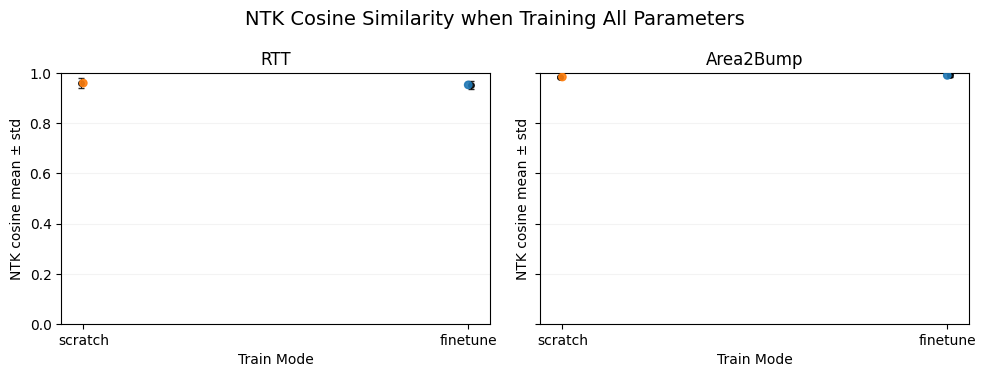

In [ ]:
# Plot NTK cosine mean ± std per opt_mode, two subplots (one per task)
import numpy as np
import matplotlib.pyplot as plt


def plot_ntk_mean_std(ntk_df_in, tasks=("mc_rtt_prepend","perich_miller_population_2018/t_20130903_center_out_reaching", "mc_area2bump_prepend"), order=("scratch", "finetune")):
    if ntk_df_in is None or len(ntk_df_in) == 0:
        print("ntk_df is empty; compute it first.")
        return
    df = ntk_df_in.copy()
    palette = {"scratch": "tab:orange", "finetune": "tab:blue", "unknown": "gray"}

    # Use provided mean/std columns if present; else fall back to point estimate and zero std
    if "ntk_cosine_mean" not in df.columns and "ntk_cosine_init_vs_best" in df.columns:
        df["ntk_cosine_mean"] = df["ntk_cosine_init_vs_best"].astype(float)
    if "ntk_cosine_std" not in df.columns:
        df["ntk_cosine_std"] = 0.0

    # Ensure types
    df["opt_mode"] = df["opt_mode"].astype(str)
    df["train_mode"] = df["train_mode"].astype(str).str.lower()

    for om in sorted(df["opt_mode"].unique()):
        sub = df[df["opt_mode"] == om]
        fig, axes = plt.subplots(1, 2, figsize=(10, 3.8), sharey=True)
        for ax, task in zip(axes, tasks):
            g = sub[sub["task"] == task].copy()
            ax.set_title('RTT' if task == 'mc_rtt_prepend' else 'Area2Bump')
            ax.set_xlabel("Train Mode")
            ax.set_ylim(0, 1)
            ax.grid(True, axis="y", alpha=0.15, zorder=0)
            if g.empty:
                continue
            # Clip visually to [-1, 1] to avoid tiny numerical overshoots
            means = g["ntk_cosine_mean"].astype(float).clip(-1, 1).values
            stds = g["ntk_cosine_std"].astype(float).values
            tms = g["train_mode"].astype(str).values
            # Map train_mode to x positions and add small jitter for visibility
            x_map = {tm: i for i, tm in enumerate(order)}
            rng = np.random.default_rng(0)
            xs_center = np.array([x_map.get(tm, len(order)) for tm in tms], dtype=float)
            xs = xs_center + rng.normal(0, 0.05, size=xs_center.shape)
            colors = [palette.get(tm, "gray") for tm in tms]
            # Error bars (mean ± std)
            ax.errorbar(xs, means, yerr=stds, fmt="o", ms=4, lw=1, ecolor="k", elinewidth=0.8, capsize=2, color="k", alpha=0.85, zorder=2)
            # Overlay colored points at category centers for legend cues
            ax.scatter(xs_center, means, c=colors, s=28, alpha=0.9, zorder=3)
            ax.set_xticks(range(len(order)))
            ax.set_xticklabels(order)
            ax.set_ylabel("NTK cosine similarity")
        fig.suptitle(f"NTK Cosine Similarity Bet", fontsize=14)
        fig.tight_layout()
        
        return fig


# Run the plot for current ntk_df
fig = plot_ntk_mean_std(ntk_df)
WRITE_FIG_DIR = '/cs/student/projects1/ml/2024/mlaimon/UCL-ML-Thesis/Writeup/figures'

fig.savefig(os.path.join(WRITE_FIG_DIR,"ntk_cosine_mean_std_per_optmode.pdf"), dpi=300)

In [34]:
# Pivot r2 per dataset_name comparing finetune vs scratch for l2_reaching_checkpoint and task=pm_center_out
import numpy as np
import pandas as pd

# Use in-memory downstream_df if available, else try to load the saved CSV
try:
    df_src = downstream_df
except NameError:
    df_src = pd.read_csv('results/raw_downstream_performances.csv')

# Filter
_df = df_src.copy()
_df['train_mode'] = _df['train_mode'].astype(str).str.lower()
mask = (
    (_df['checkpoint_short'] == 'l2_reaching_checkpoint') &
    (_df['task'] == 'pm_center_out') &
    (_df['opt_mode'].isin(['all']))
)
subset = _df.loc[mask, ['dataset_name', 'train_mode', 'r2']].dropna(subset=['dataset_name', 'r2'])

# Pivot with mean aggregation in case of multiple runs per group
pivot = pd.pivot_table(
    subset,
    index='dataset_name',
    columns='train_mode',
    values='r2',
    aggfunc='mean'
)

# Ensure both columns exist and order them
for col in ['finetune', 'scratch']:
    if col not in pivot.columns:
        pivot[col] = np.nan
pivot = pivot[['finetune', 'scratch']]

# Add delta column for quick comparison
pivot['delta_finetune_minus_scratch'] = pivot['finetune'] - pivot['scratch']

# Sort for readability and display
pivot = pivot.sort_values('delta_finetune_minus_scratch', ascending=False).reset_index()
pivot

train_mode,dataset_name,finetune,scratch,delta_finetune_minus_scratch
0,perich_miller_population_2018/t_20130909_cente...,0.877347,0.898996,-0.021649
1,perich_miller_population_2018/t_20130819_cente...,0.787701,0.812708,-0.025007
2,perich_miller_population_2018/t_20130823_cente...,0.843992,0.874293,-0.030301
3,perich_miller_population_2018/t_20130905_cente...,0.782842,0.831280,-0.048438
4,perich_miller_population_2018/t_20130903_cente...,0.800289,0.856410,-0.056121
5,perich_miller_population_2018/t_20130821_cente...,0.826908,NaN,NaN


In [ ]:
pivot.dataset_name

In [33]:
from foundational_ssm.models import SSMFoundationalDecoder
art_epoch0 = 'melinajingting-ucl/foundational_ssm_pretrain/l2_reaching_checkpoint:epoch_0'
art_best = 'melinajingting-ucl/foundational_ssm_pretrain/l2_reaching_checkpoint:epoch_500'
model0, state0, _ = load_model_and_state_from_checkpoint_wandb(art_epoch0, model_cls=SSMFoundationalDecoder)
modelB, stateB, _ = load_model_and_state_from_checkpoint_wandb(art_best, model_cls=SSMFoundationalDecoder)


# Parameter-space distances
p0_arr, _ = eqx.partition(model0, eqx.is_inexact_array)
pB_arr, _ = eqx.partition(modelB, eqx.is_inexact_array)
diff_arr = jax.tree_util.tree_map(lambda b, a: b - a, pB_arr, p0_arr)
norm_init = _tree_l2_norm(p0_arr)
norm_final = _tree_l2_norm(pB_arr)
norm_diff = _tree_l2_norm(diff_arr)
param_rel_l2 = float(norm_diff / (norm_init + 1e-12))
param_abs_l2 = float(norm_diff)

wandb:   3 of 3 files downloaded.  
wandb:   3 of 3 files downloaded.  


In [34]:
norm_init

1005.7750244140625

In [ ]:
# Per-leaf L2 norms for init/final/delta parameters
import numpy as np
import jax
import jax.numpy as jnp
import pandas as pd


def _leaf_paths_and_arrays(tree):
    """Return (names, arrays) for float leaves; try to use key paths if available."""
    names = []
    arrays = []
    try:
        from jax.tree_util import tree_flatten_with_path, keystr  # newer JAX
        pairs, _ = tree_flatten_with_path(tree)
        for kp, leaf in pairs:
            arr = jnp.asarray(leaf)
            if jnp.issubdtype(arr.dtype, jnp.floating):
                try:
                    nm = keystr(kp)
                except Exception:
                    nm = str(kp)
                names.append(nm)
                arrays.append(arr)
    except Exception:
        # Fallback: plain flatten with index-based names
        leaves = jax.tree_util.tree_leaves(tree)
        for i, leaf in enumerate(leaves):
            arr = jnp.asarray(leaf)
            if jnp.issubdtype(arr.dtype, jnp.floating):
                names.append(f"leaf[{i}]")
                arrays.append(arr)
    return names, arrays


def compute_per_leaf_norm_table(p0_arr, pB_arr):
    """Build a DataFrame with per-leaf L2 norms for init/final and their difference.
    Expects p0_arr and pB_arr to have identical pytree structure (e.g., from eqx.partition).
    """
    names0, L0 = _leaf_paths_and_arrays(p0_arr)
    namesB, LB = _leaf_paths_and_arrays(pB_arr)
    if len(L0) != len(LB):
        raise ValueError(f"Mismatched number of leaves: {len(L0)} vs {len(LB)}")
    # If names differ but lengths match, prefer names0
    rows = []
    for i, (nm, a0, aB) in enumerate(zip(names0, L0, LB)):
        d = aB - a0
        n0 = float(jnp.sqrt(jnp.sum(a0 * a0)))
        nB = float(jnp.sqrt(jnp.sum(aB * aB)))
        nd = float(jnp.sqrt(jnp.sum(d * d)))
        rel = float(nd / (n0 + 1e-12)) if n0 > 0 else np.inf
        rows.append({
            'idx': i,
            'leaf': nm,
            'shape': tuple(a0.shape),
            'init_norm': n0,
            'final_norm': nB,
            'diff_norm': nd,
            'rel_change': rel,
        })
    df = pd.DataFrame(rows)
    return df


wandb:   3 of 3 files downloaded.  
wandb:   3 of 3 files downloaded.  


In [43]:
art_epoch0 = 'melinajingting-ucl/foundational_ssm_downstream_sweep/scratch_l2_reaching_mc_rtt_prepend_all_checkpoint:epoch_0'
art_best = 'melinajingting-ucl/foundational_ssm_downstream_sweep/finetuned_l2_reaching_mc_rtt_prepend_all_checkpoint:epoch_0'
model0, state0, _ = load_model_and_state_from_checkpoint_wandb(art_epoch0, model_cls=SSMDownstreamDecoder)
modelB, stateB, _ = load_model_and_state_from_checkpoint_wandb(art_best, model_cls=SSMDownstreamDecoder)


# Parameter-space distances
p0_arr, _ = eqx.partition(model0, eqx.is_inexact_array)
pB_arr, _ = eqx.partition(modelB, eqx.is_inexact_array)
diff_arr = jax.tree_util.tree_map(lambda b, a: b - a, pB_arr, p0_arr)
norm_init = _tree_l2_norm(p0_arr)
norm_final = _tree_l2_norm(pB_arr)
norm_diff = _tree_l2_norm(diff_arr)
param_rel_l2 = float(norm_diff / (norm_init + 1e-12))
param_abs_l2 = float(norm_diff)

leaf_df = compute_per_leaf_norm_table(p0_arr, pB_arr)
leaf_df_sorted = leaf_df.sort_values('diff_norm', ascending=False).reset_index(drop=True)
# Print summary totals to cross-check against whole-tree norms
print(f"Totals — init: {norm_init:.6g}, final: {norm_final:.6g}, diff: {norm_diff:.6g}, rel: {param_rel_l2:.6g}")
# Show top-k leaves by change; adjust k as needed
k = 50
display_cols = ['idx','leaf','shape','init_norm','final_norm','diff_norm','rel_change']
try:
    from IPython.display import display
    display(leaf_df_sorted[display_cols].head(k))
except Exception:
    print(leaf_df_sorted[display_cols].head(k).to_string(index=False))

wandb:   3 of 3 files downloaded.  
wandb:   3 of 3 files downloaded.  
wandb:   3 of 3 files downloaded.  
wandb:   3 of 3 files downloaded.  


Totals — init: 1005.37, final: 1005.99, diff: 240.913, rel: 0.239626


,idx,leaf,shape,init_norm,final_norm,diff_norm,rel_change
0,13,.ssm_blocks[1].ssm.Lambda_re,"(64,)",4.000000,168.956604,166.900909,41.725227
1,11,.ssm_blocks[0].glu.w2.weight,"(256, 256)",9.218109,77.363251,77.923035,8.453256
2,21,.ssm_blocks[1].glu.w2.weight,"(256, 256)",9.213978,66.753723,67.373550,7.312103
3,9,.ssm_blocks[0].glu.w1.weight,"(256, 256)",9.243192,65.004967,65.636040,7.101015
4,3,.ssm_blocks[0].ssm.Lambda_re,"(64,)",4.000000,59.352539,55.734386,13.933597
5,19,.ssm_blocks[1].glu.w1.weight,"(256, 256)",9.230971,51.106293,51.959572,5.628830
6,6,.ssm_blocks[0].ssm.C,"(256, 64, 2)",16.036882,38.254009,41.538425,2.590181
7,14,.ssm_blocks[1].ssm.Lambda_im,"(64,)",708.838501,673.616821,39.415257,0.055605
8,5,.ssm_blocks[0].ssm.B,"(64, 256, 2)",11.271930,36.830017,38.468803,3.412797
9,15,.ssm_blocks[1].ssm.B,"(64, 256, 2)",11.327927,36.696239,38.331257,3.383784


In [41]:

from foundational_ssm.models import SSMFoundationalDecoder
art_epoch0 = 'melinajingting-ucl/foundational_ssm_pretrain/l2_reaching_checkpoint:epoch_0'
art_best = 'melinajingting-ucl/foundational_ssm_pretrain/l2_reaching_checkpoint:epoch_500'
model0, state0, _ = load_model_and_state_from_checkpoint_wandb(art_epoch0, model_cls=SSMFoundationalDecoder)
modelB, stateB, _ = load_model_and_state_from_checkpoint_wandb(art_best, model_cls=SSMFoundationalDecoder)


# Parameter-space distances
p0_arr, _ = eqx.partition(model0, eqx.is_inexact_array)
pB_arr, _ = eqx.partition(modelB, eqx.is_inexact_array)
diff_arr = jax.tree_util.tree_map(lambda b, a: b - a, pB_arr, p0_arr)
norm_init = _tree_l2_norm(p0_arr)
norm_final = _tree_l2_norm(pB_arr)
norm_diff = _tree_l2_norm(diff_arr)
param_rel_l2 = float(norm_diff / (norm_init + 1e-12))
param_abs_l2 = float(norm_diff)

leaf_df = compute_per_leaf_norm_table(p0_arr, pB_arr)
leaf_df_sorted = leaf_df.sort_values('diff_norm', ascending=False).reset_index(drop=True)
# Print summary totals to cross-check against whole-tree norms
print(f"Totals — init: {norm_init:.6g}, final: {norm_final:.6g}, diff: {norm_diff:.6g}, rel: {param_rel_l2:.6g}")
# Show top-k leaves by change; adjust k as needed
k = 50
display_cols = ['idx','leaf','shape','init_norm','final_norm','diff_norm','rel_change']
display(leaf_df_sorted[display_cols].head(k))

wandb:   3 of 3 files downloaded.  
wandb:   3 of 3 files downloaded.  
wandb:   3 of 3 files downloaded.  
wandb:   3 of 3 files downloaded.  


Totals — init: 1005.78, final: 1039.91, diff: 353.186, rel: 0.351158


,idx,leaf,shape,init_norm,final_norm,diff_norm,rel_change
0,30,.ssm_blocks[1].ssm.Lambda_re,"(64,)",4.000000,168.956604,166.900909,41.725227
1,10,.encoders[5].weight,"(256, 625)",9.243948,120.745110,120.594513,13.045780
2,12,.encoders[6].weight,"(256, 625)",9.222424,119.452431,119.349434,12.941222
3,0,.encoders[0].weight,"(256, 625)",9.227246,111.767258,111.671295,12.102343
4,6,.encoders[3].weight,"(256, 625)",9.225576,105.279434,105.222168,11.405484
5,4,.encoders[2].weight,"(256, 625)",9.236206,76.625015,76.631821,8.296894
6,28,.ssm_blocks[0].glu.w2.weight,"(256, 256)",9.272792,77.363251,76.324532,8.231020
7,2,.encoders[1].weight,"(256, 625)",9.220180,67.577545,67.503502,7.321278
8,38,.ssm_blocks[1].glu.w2.weight,"(256, 256)",9.263729,66.753723,66.546471,7.183551
9,26,.ssm_blocks[0].glu.w1.weight,"(256, 256)",9.202188,65.004967,63.515987,6.902270
